In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.model_selection import train_test_split
import csv
import cv2

# Data exploration and pre-processing

In [2]:
datapath = 'drive_circ1_merged/'
sideImages_datapath = 'drive_circ1_sideImages/'

In [3]:
imgfileList = []
steerList = []

with open(datapath+'driving_log.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        imgfileList.append(row[0].replace('\\','/').lstrip())  # windows compatibility
        steerList.append(row[3])

iNumCenterImg = len(imgfileList)
print('number of centered images :', iNumCenterImg)
        
deltaSteerSideImages = 0.06  # arctan( 1.2m camera offset / 20m until shift is corrected )
deltaSteerSideImages = 0.1
with open(sideImages_datapath+'driving_log.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        # left camera image
        imgfileList.append(row[1].replace('\\','/').lstrip())  # windows compatibility
        steerList.append( float(row[3])+deltaSteerSideImages )
        # right camera image
        imgfileList.append(row[2].replace('\\','/').lstrip())  # windows compatibility
        steerList.append( float(row[3])-deltaSteerSideImages )        

# pre-process labels
y = np.array(steerList, np.float32)

print('total number of images :', len(y))


number of centered images : 25376
total number of images : 41448


len(y) : 41448
y.min() : -1.0427
y.max() : 1.1


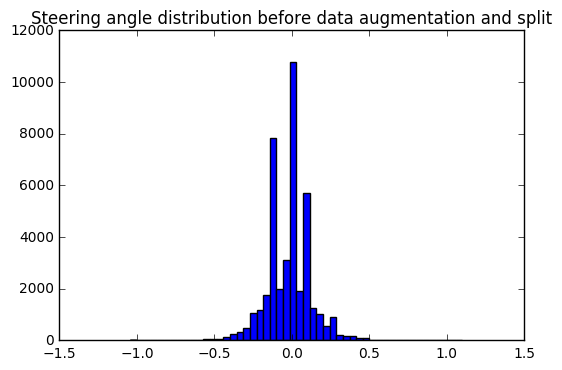

In [4]:
print("len(y) :", len(y))
print("y.min() :", y.min())
print("y.max() :", y.max())

plt.hist(y, 50)
plt.title("Steering angle distribution before data augmentation and split")
plt.show()

In [5]:
img = mpimg.imread( datapath+imgfileList[0] )

print("img.dtype :", img.dtype)
imgshape = img.shape
print("img.shape : ", imgshape)
print("np.prod(imgshape) :", np.prod(imgshape))
print("img.min() : ", img.min())
print("img.max() : ", img.max())

img.dtype : uint8
img.shape :  (160, 320, 3)
np.prod(imgshape) : 153600
img.min() :  0
img.max() :  255


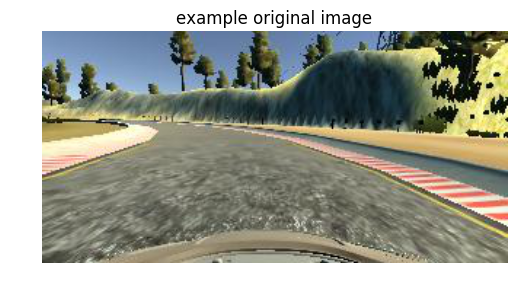

In [6]:
plt.imshow(img)
plt.axis('off')
plt.title('example original image')
plt.show()

# Data pre-processing

In [7]:

def crop_top_bottom_rows(img, numRowsBottomCropped=20, numRowsTopCropped=55):
    imgMod = np.empty((img.shape[0]-numRowsBottomCropped-numRowsTopCropped, img.shape[1], img.shape[2]), dtype=img.dtype)
    imgMod[:] = img[numRowsTopCropped:img.shape[0]-numRowsBottomCropped]
    return imgMod


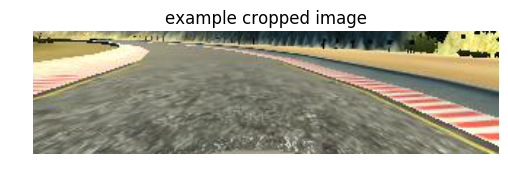

cropped img shape : (85, 320, 3)


In [8]:
i=0
img=mpimg.imread( datapath+imgfileList[i] )
plt.imshow( crop_top_bottom_rows(img) )
plt.axis('off')
plt.title('example cropped image')
plt.show()
print("cropped img shape :", crop_top_bottom_rows(img).shape)

In [9]:

def preprocessImage(img, numRowsBottomCropped=20, numRowsTopCropped=55, newNumRows=32, newNumCols=120):
    img = crop_top_bottom_rows(img, numRowsBottomCropped, numRowsTopCropped)
    return cv2.resize(img, (newNumCols, newNumRows)).astype(np.float32)  # retype and resize


In [10]:
i=0
img = mpimg.imread( datapath+imgfileList[i] )
imgn = preprocessImage(img)

In [11]:
print("imgn.dtype :", imgn.dtype)
imgshape = imgn.shape
print("imgn.shape :", imgshape)
print("imgn.min() :", imgn.min())
print("imgn.max() :", imgn.max())
print("imgn.mean() :", imgn.mean())
print("imgn.std() :", imgn.std())

imgn.dtype : float32
imgn.shape : (32, 120, 3)
imgn.min() : 0.0
imgn.max() : 255.0
imgn.mean() : 129.585
imgn.std() : 46.3707


In [12]:

import os.path

X = np.empty( (len(imgfileList), *imgshape), np.float32)

# Load and pre-process images from centre camera
for i in range(iNumCenterImg):
    fname = datapath+imgfileList[i]
    if os.path.isfile(fname): 
        X[i] = preprocessImage( mpimg.imread(fname) )
    else:
        print('image file '+fname+' does not exist!')

# Load and pre-process images from side cameras
for i in range(iNumCenterImg, len(imgfileList)):
    fname = sideImages_datapath+imgfileList[i]
    if os.path.isfile(fname): 
        X[i] = preprocessImage( mpimg.imread(fname) )
    else:
        print('image file '+fname+' does not exist!')

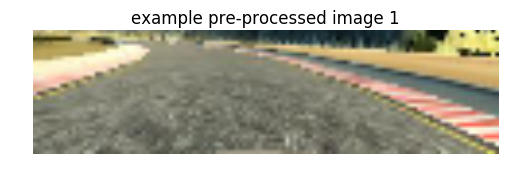

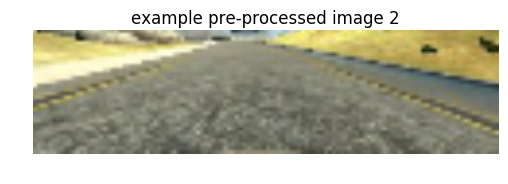

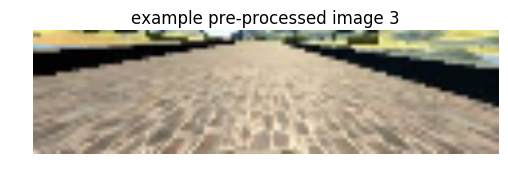

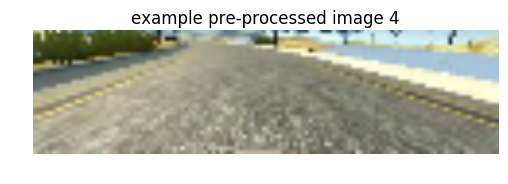

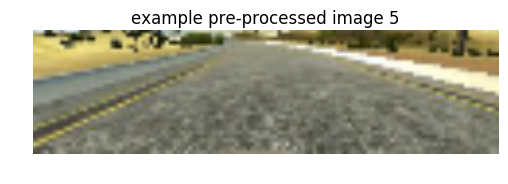

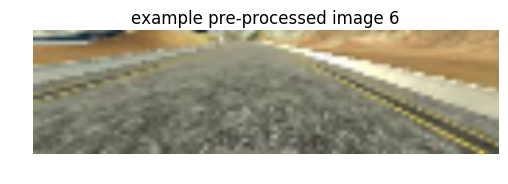

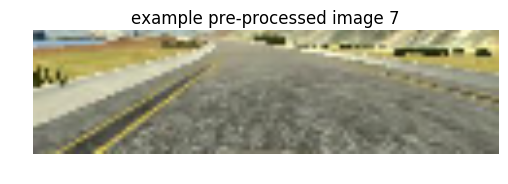

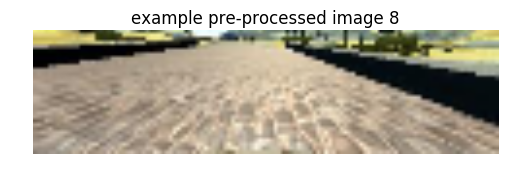

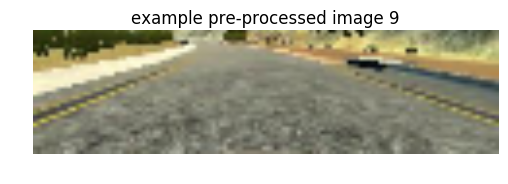

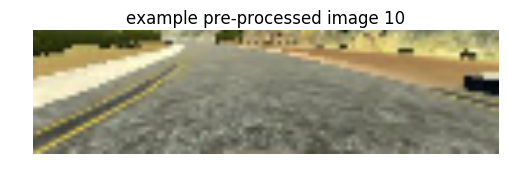

In [13]:
for i in range(10):
    plt.imshow( X[1000*i].astype(np.uint8) )
    plt.axis('off')
    plt.title('example pre-processed image {}'.format(i+1))
    plt.show()

# Data augmentation

In [14]:
def transform_colorChannels(img, minH=0.8, maxH=1.2, minS=0.7, maxS=1, minV=0.40, maxV=1.2):
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    random_H = minH + np.random.uniform()*(maxH-minH)
    random_S = minS + np.random.uniform()*(maxS-minS)
    random_V = minV + np.random.uniform()*(maxV-minV)
    img[:,:,0] = img[:,:,0]*random_H
    img[:,:,1] = img[:,:,1]*random_S
    img[:,:,2] = img[:,:,2]*random_V
    
    img = np.minimum(img, 255)
    img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    
    return img

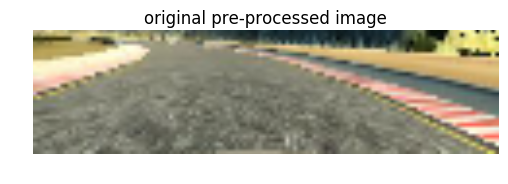

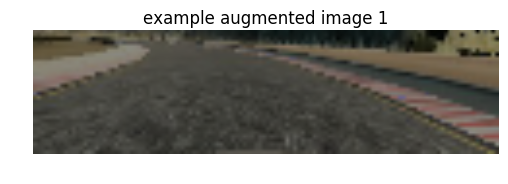

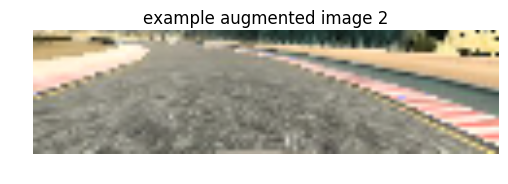

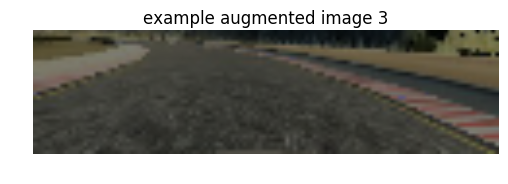

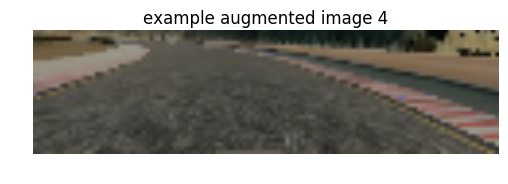

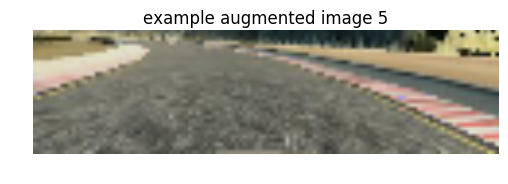

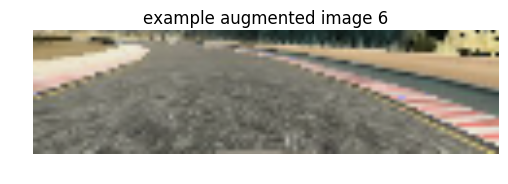

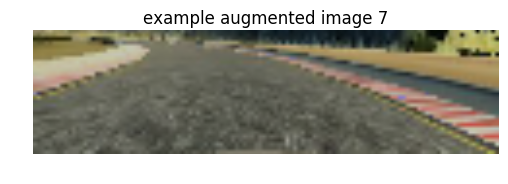

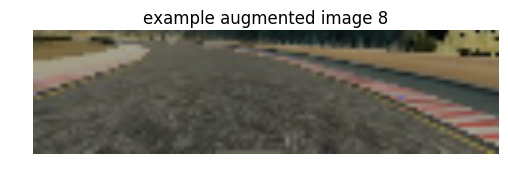

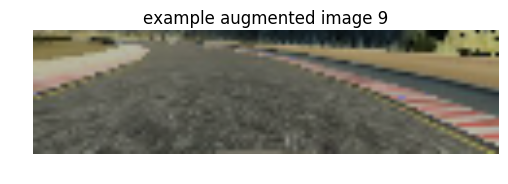

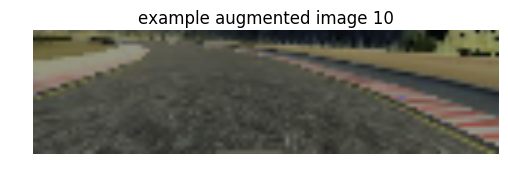

In [15]:
img = X[0]

plt.imshow( img.astype(np.uint8)[:,:,:] )
plt.title('original pre-processed image')
plt.axis('off')
plt.show()

for i in range(10):
    imga = transform_colorChannels(img).astype(np.uint8)
    plt.imshow( imga[:,:,:] )
    plt.title('example augmented image {}'.format(i+1))
    plt.axis('off')
    plt.show()


In [16]:
def transform_shift(img, steer, hShiftMin=-35, hShiftMax=35, vShiftMin=-10, vShiftMax=10 ):
    
    random_hShift = hShiftMin + np.random.uniform()*(hShiftMax-hShiftMin)
    random_vShift = vShiftMin + np.random.uniform()*(vShiftMax-vShiftMin)
    
    shiftMatrix = np.float32( [[1,0,random_hShift], [0,1,random_vShift]] )
    imgMod = cv2.warpAffine(img, shiftMatrix, (img.shape[1],img.shape[0]))
    steerMod = steer + 0.01*random_hShift  # 0.01 rad (0.57 deg) per pixel
    return imgMod,steerMod

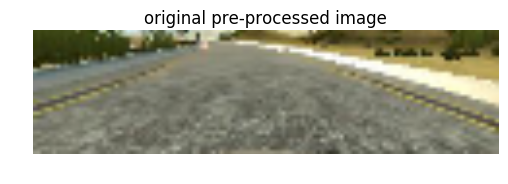

steer: -0.05


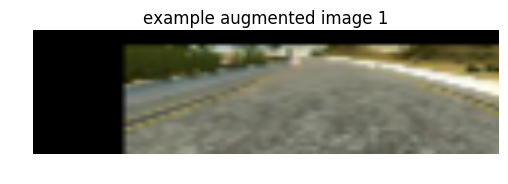

steer: 0.185168217257


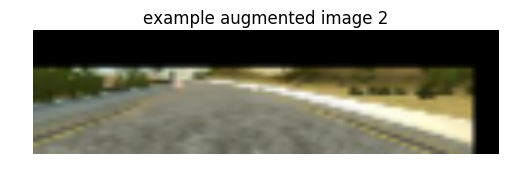

steer: -0.116062139175


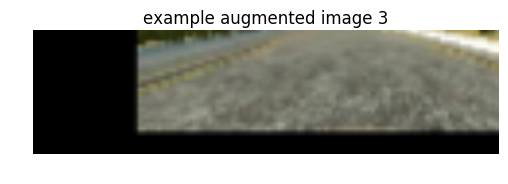

steer: 0.218275605


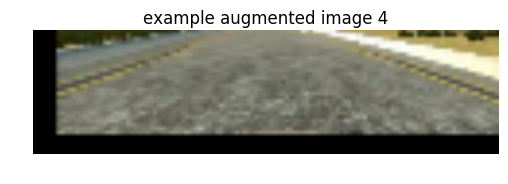

steer: 0.0115482804806


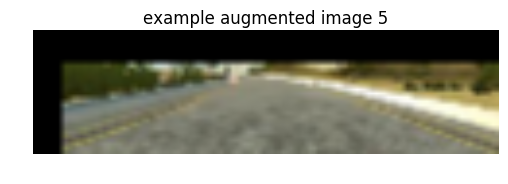

steer: 0.0252431921472


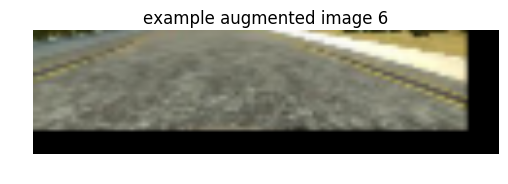

steer: -0.132480587475


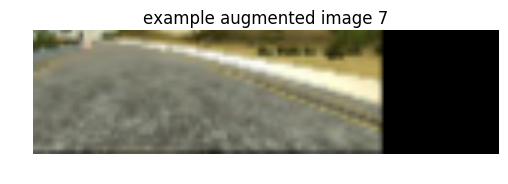

steer: -0.352556750791


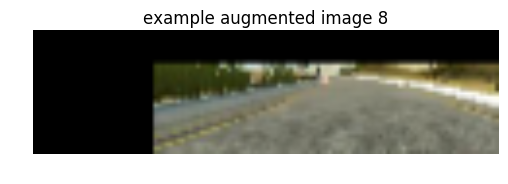

steer: 0.260493281044


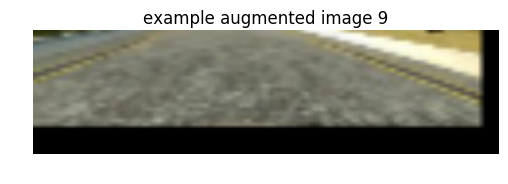

steer: -0.0950377050413


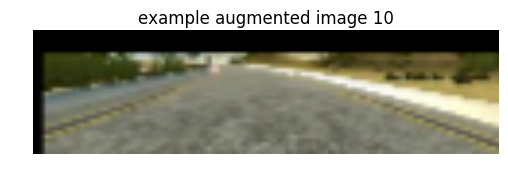

steer: -0.0233322556085


In [17]:
i=5200
img = X[i]
steerOrig = y[i]

plt.imshow( img.astype(np.uint8)[:,:,:] )
plt.title('original pre-processed image')
plt.axis('off')
plt.show()
print("steer:", steerOrig)

for i in range(10):
    imga, steer = transform_shift(img, steerOrig)
    plt.imshow( imga[:,:,:].astype(np.uint8) )
    plt.title('example augmented image {}'.format(i+1))
    plt.axis('off')
    plt.show()
    print("steer:", steer)


In [18]:

def transform_shadow(img, pShadow=0.5, brightMin=0.6, brightMax=1.0):
    
    # transform image to HLS
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    x1 = np.random.uniform()*img.shape[1]
    x2 = np.random.uniform()*img.shape[1]
    y1 = np.random.uniform()*img.shape[0]
    y2 = np.random.uniform()*img.shape[0]
    
    X_m = np.mgrid[0:img.shape[0], 0:img.shape[1]][0]
    Y_m = np.mgrid[0:img.shape[0], 0:img.shape[1]][1]
    
    shadow_mask = 0*img[:,:,1]
    shadow_mask[( (X_m-x1)*(y2-y1) - (x2-x1)*(Y_m-y1) >=0 )]=1
    
    if np.random.uniform() < pShadow:
        
        brightness =  brightMin + np.random.uniform()*(brightMax-brightMin)
        cond0 = shadow_mask==0
        cond1 = shadow_mask==1
        
        # randomly choose which side to shade
        if np.random.randint(2)==1:
            img[:,:,1][cond1] = img[:,:,1][cond1]*brightness
        else:
            img[:,:,1][cond0] = img[:,:,1][cond0]*brightness    
    
    # transform back to RGB
    return cv2.cvtColor(img, cv2.COLOR_HLS2RGB)


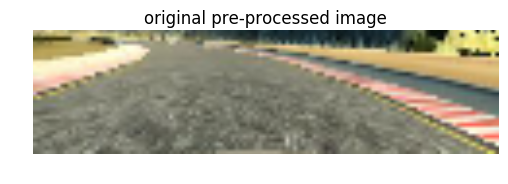

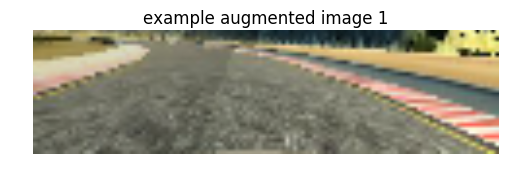

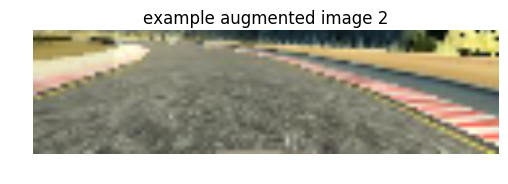

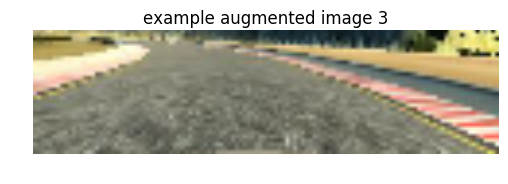

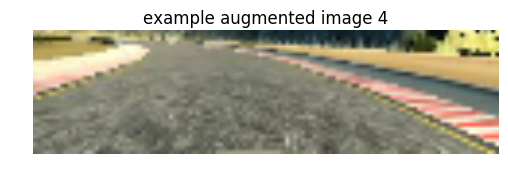

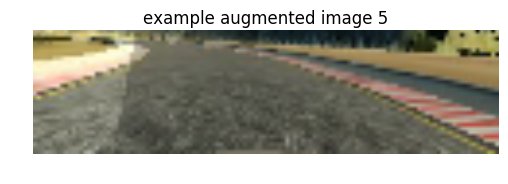

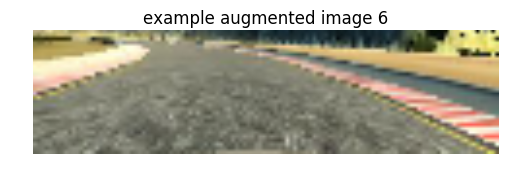

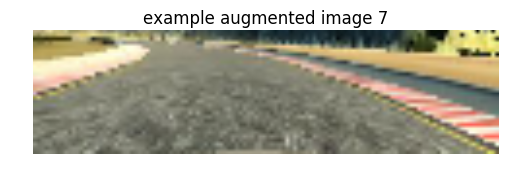

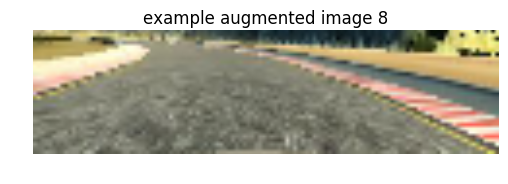

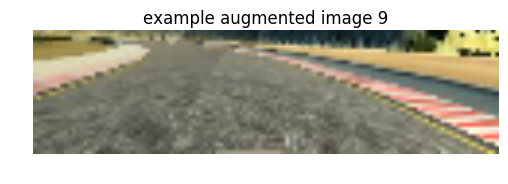

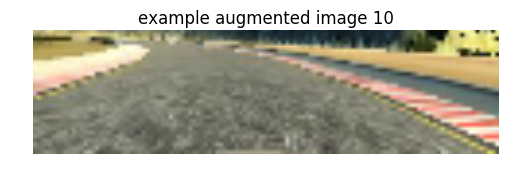

In [19]:
i=0
img = X[i]

plt.imshow( img.astype(np.uint8)[:,:,:] )
plt.title('original pre-processed image')
plt.axis('off')
plt.show()

for i in range(10):
    imga = transform_shadow(img).astype(np.uint8)
    plt.imshow( imga[:,:,:] )
    plt.title('example augmented image {}'.format(i+1))
    plt.axis('off')
    plt.show()

In [20]:
def transform_flip(img, steer, pFlip=0.5 ):
    if np.random.uniform() < pFlip:
        img = cv2.flip(img, 1)
        steer = -steer
    return img, steer

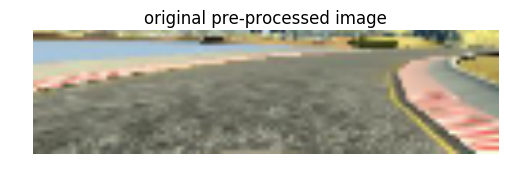

steer : 0.2


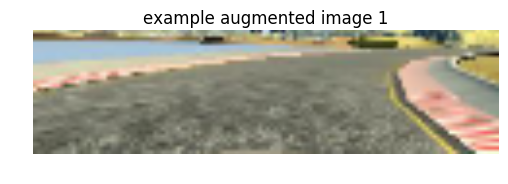

steer : 0.2


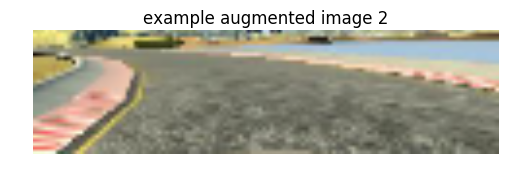

steer : -0.2


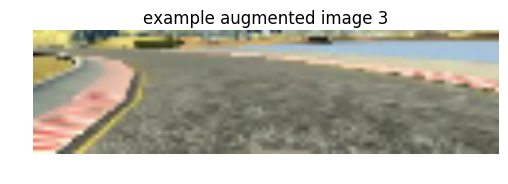

steer : -0.2


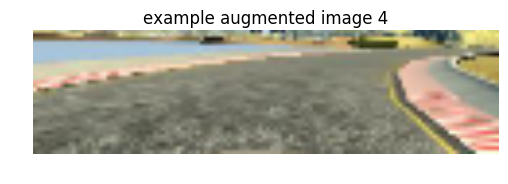

steer : 0.2


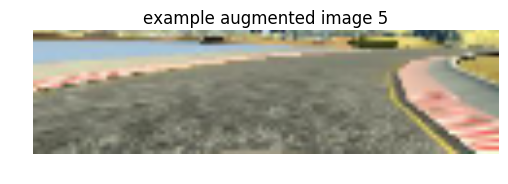

steer : 0.2


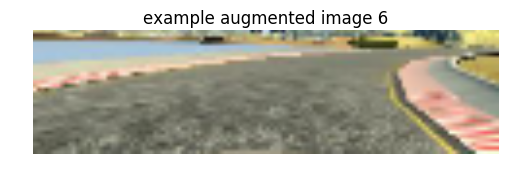

steer : 0.2


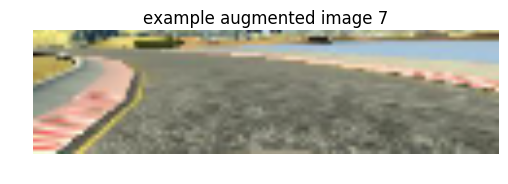

steer : -0.2


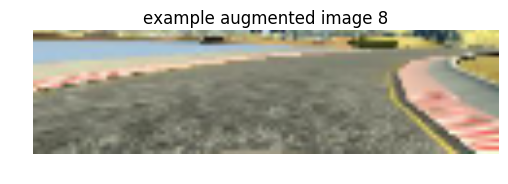

steer : 0.2


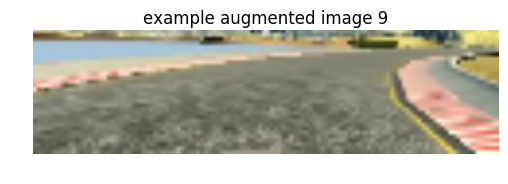

steer : 0.2


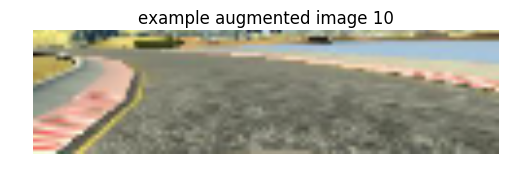

steer : -0.2


In [21]:
i = 3430
img = X[i]
steerOrig = y[i]

plt.imshow( img.astype(np.uint8)[:,:,:] )
plt.title('original pre-processed image')
plt.axis('off')
plt.show()
print('steer :', steerOrig)

for i in range(10):
    imga, steer = transform_flip(img, steerOrig)
    plt.imshow( imga[:,:,:].astype(np.uint8) )
    plt.title('example augmented image {}'.format(i+1))
    plt.axis('off')
    plt.show()
    print('steer :', steer)

In [22]:
def transform_shear(img, steer, shearPixelsRange=30):
    
    rows, cols, ch = img.shape
    
    dx = np.random.randint(-shearPixelsRange, shearPixelsRange+1)
    
    points1 = np.float32([[0,rows], [cols,rows], [cols/2,rows/2]])
    points2 = np.float32([[0,rows], [cols,rows], [cols/2+dx, rows/2]])
    
    M = cv2.getAffineTransform(points1, points2)
    img = cv2.warpAffine(img, M, (cols,rows), borderMode=1)
    steer += 0.010*dx  # 0.01 rad (0.57 deg) per pixel
    
    return img, steer

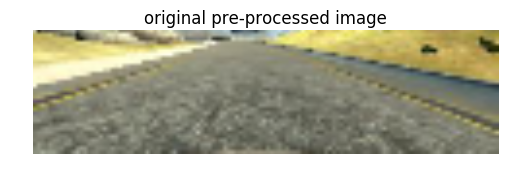

steer : 0.0


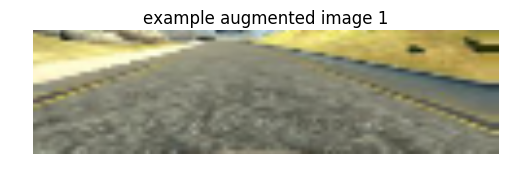

steer : -0.02


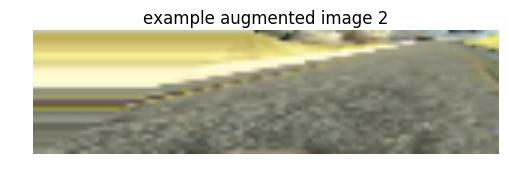

steer : 0.28


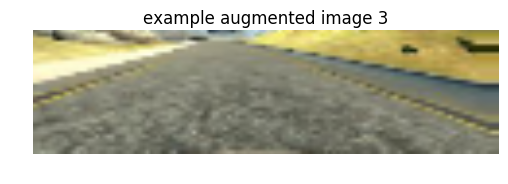

steer : -0.03


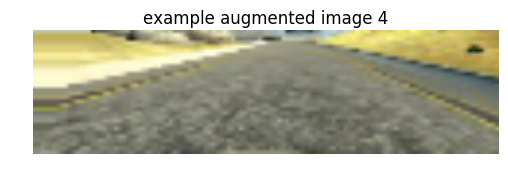

steer : 0.07


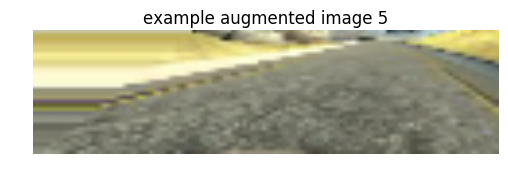

steer : 0.2


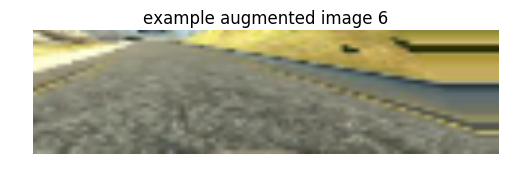

steer : -0.12


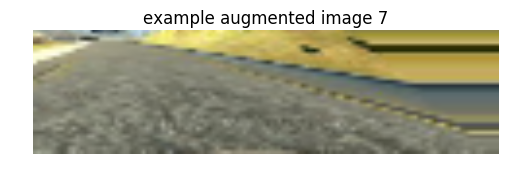

steer : -0.18


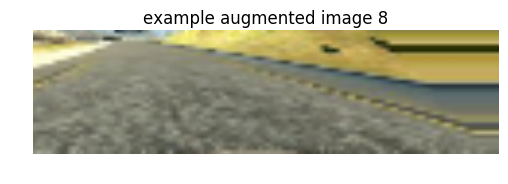

steer : -0.15


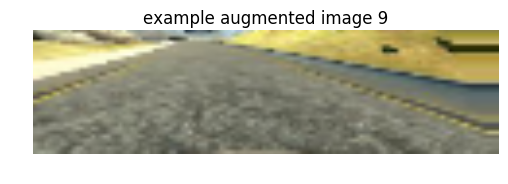

steer : -0.06


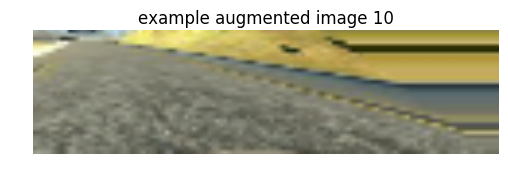

steer : -0.21


In [23]:
i = 1000
img = X[i]
steerOrig = y[i]

plt.imshow( img.astype(np.uint8)[:,:,:] )
plt.title('original pre-processed image')
plt.axis('off')
plt.show()
print('steer :', steerOrig)

for i in range(10):
    imga, steer = transform_shear(img, steerOrig)
    plt.imshow( imga[:,:,:].astype(np.uint8) )
    plt.title('example augmented image {}'.format(i+1))
    plt.axis('off')
    plt.show()
    print('steer :', steer)

In [24]:
def random_transform(img, steer):
    img, steer = transform_flip(img, steer)
    img = transform_colorChannels(img)
    img = transform_shadow(img)
    img, steer = transform_shear(img, steer)
    img, steer = transform_shift(img, steer)
    
    return img, steer
    

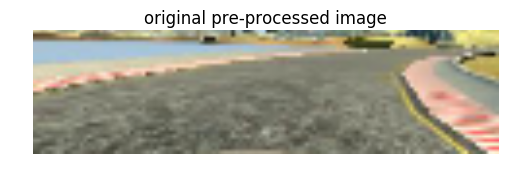

steer : 0.2


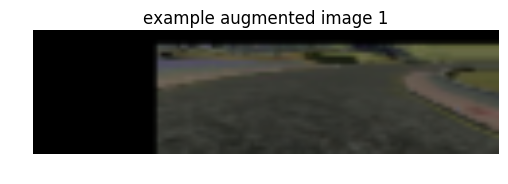

steer : 0.287823103727


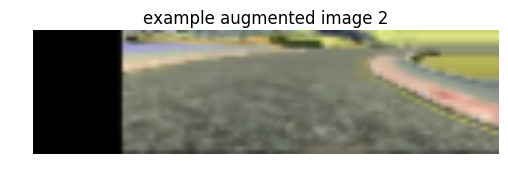

steer : 0.199118809756


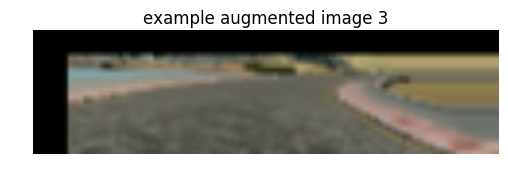

steer : 0.0990597474996


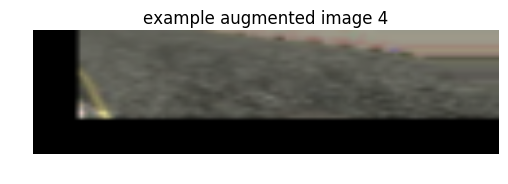

steer : -0.373758963755


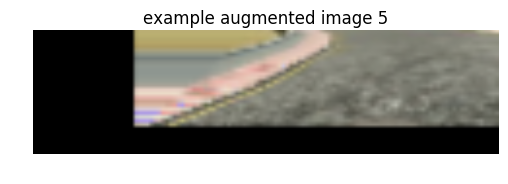

steer : 0.25072018307


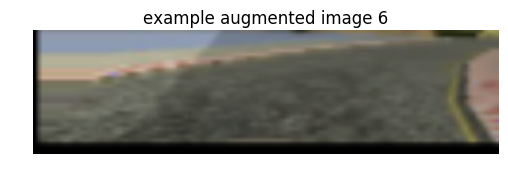

steer : 0.333429245315


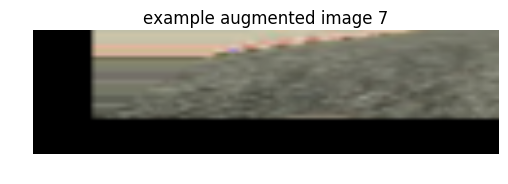

steer : 0.622903045751


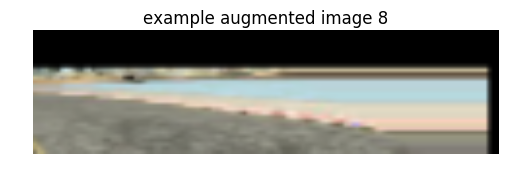

steer : -0.477045045575


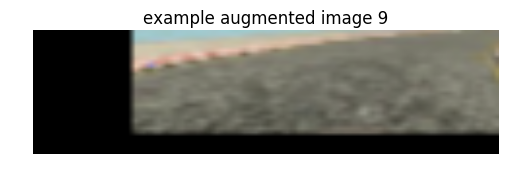

steer : 0.445237995068


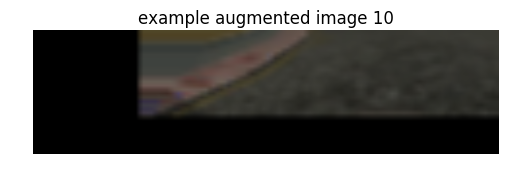

steer : 0.213352191535


In [25]:
i = 3431
img = X[i]
steerOrig = y[i]

plt.imshow( img.astype(np.uint8)[:,:,:] )
plt.title('original pre-processed image')
plt.axis('off')
plt.show()
print('steer :', steerOrig)

for i in range(10):
    imga, steer = random_transform(img, steerOrig)
    plt.imshow( imga[:,:,:].astype(np.uint8) )
    plt.title('example augmented image {}'.format(i+1))
    plt.axis('off')
    plt.show()
    print('steer :', steer)

# Augmented training data generator

In [26]:
# python generator of augmented train data for fit_generator

def generate_train_data(X, y, batch_size=32):
    
    batch_X = np.empty((batch_size, *X_train.shape[1:]))
    batch_y = np.empty(batch_size)

    while 1:

        # draw random sample from original train dataset
        index = np.random.choice(len(X), batch_size)
        
        # randomly transform images and adjust steering angle accordingly
        for i_batch in range(batch_size):
            batch_X[i_batch], batch_y[i_batch] = random_transform( X[index[i_batch]], y[index[i_batch]] )

        yield batch_X, batch_y


# Data split in training and validation sets

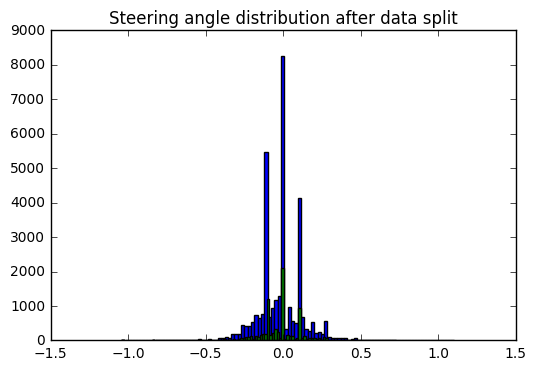

In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=785949)

del X
del y

plt.hist(y_train, 100)
plt.hist(y_val, 100)
plt.title("Steering angle distribution after data split")
plt.show()

# Create model

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Lambda
from keras.optimizers import Adam


def model3conv1fc():
    
    model = Sequential()
    
    model.add( Convolution2D(6, 5, 5, border_mode='valid', init='normal', input_shape=imgshape) )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(3, 3) ) )
    
    model.add( Convolution2D(10, 4, 4, border_mode='valid', init='normal') )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(3, 3) ) )
    
    model.add( Convolution2D(16, 4, 4, border_mode='valid', init='normal') )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(3, 2) ) )
    
    model.add( Flatten() )
    model.add( Dense(1, init='normal') )

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    
    return model



def model3conv2fc():
    
    model = Sequential()
    
    model.add( Convolution2D(12, 5, 5, border_mode='valid', init='normal', input_shape=imgshape) )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
    
    model.add( Convolution2D(20, 4, 4, border_mode='valid', init='normal') )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
    
    model.add( Convolution2D(36, 4, 4, border_mode='valid', init='normal') )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
    
    model.add( Flatten() )
    model.add( Dense(10, activation='relu', init='normal') )
    model.add( Dense(1, init='normal') )

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    
    return model



def model3conv2fcWithDropout():
    
    model = Sequential()
    
    model.add( SpatialDropout2D(0.6, dim_ordering='tf', input_shape=imgshape) )
    model.add( Convolution2D(12, 5, 5, border_mode='valid', init='normal') )
    #model.add( Convolution2D(12, 5, 5, border_mode='valid', init='normal', input_shape=imgshape) )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
    
    model.add( SpatialDropout2D(0.5, dim_ordering='tf') )
    model.add( Convolution2D(24, 4, 4, border_mode='valid', init='normal') )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
    
    model.add( Dropout(0.4) )
    model.add( Convolution2D(36, 3, 3, border_mode='valid', init='normal') )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
    
    model.add( Dropout(0.3) )
    model.add( Flatten() )
    model.add( Dense(20, activation='relu', init='normal') )
    model.add( Dense(1, init='normal') )

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    
    return model


def model4conv3fc():
    
    model = Sequential()
    
    #model.add( SpatialDropout2D(0.5, dim_ordering='tf', input_shape=imgshape) )
    #model.add( Convolution2D(12, 5, 5, border_mode='valid', init='normal') )
    model.add( Convolution2D(12, 5, 5, border_mode='valid', init='normal', input_shape=imgshape) )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
    
    #model.add( SpatialDropout2D(0.4, dim_ordering='tf') )
    model.add( Convolution2D(18, 5, 5, border_mode='valid', init='normal') )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
    
    #model.add( SpatialDropout2D(0.4, dim_ordering='tf') )
    model.add( Convolution2D(24, 5, 5, border_mode='valid', init='normal') )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
    
    #model.add( SpatialDropout2D(0.3, dim_ordering='tf') )
    model.add( Convolution2D(32, 3, 3, border_mode='valid', init='normal') )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
       
    #model.add( Dropout(0.2) )
    model.add( Flatten() )
    model.add( Dense(32, activation='relu', init='normal') )

    #model.add( Dropout(0.1) )
    model.add( Dense(12, activation='relu', init='normal') )
    
    #model.add( Dropout(0.1) )
    model.add( Dense(1, init='normal') )
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    
    return model



def model4conv3fc_withDropout():
    
    model = Sequential()
    
    model.add( Lambda(lambda x: x/255-0.5, input_shape=imgshape) )
    
    #model.add( SpatialDropout2D(0.5, dim_ordering='tf', input_shape=imgshape) )
    model.add( Convolution2D(12, 5, 5, border_mode='valid', init='normal') )
    #model.add( Convolution2D(12, 5, 5, border_mode='valid', init='normal', input_shape=imgshape) )
    
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
    
    #model.add( SpatialDropout2D(0.3, dim_ordering='tf') )
    model.add( Convolution2D(18, 5, 5, border_mode='valid', init='normal') )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
    
    model.add( SpatialDropout2D(0.2, dim_ordering='tf') )
    model.add( Convolution2D(24, 5, 5, border_mode='valid', init='normal') )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
    
    model.add( Dropout(0.3) )
    model.add( Convolution2D(32, 3, 3, border_mode='valid', init='normal') )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
       
    model.add( Dropout(0.5) )
    model.add( Flatten() )
    model.add( Dense(32, activation='relu', init='normal') )

    #model.add( Dropout(0.2) )
    model.add( Dense(12, activation='relu', init='normal') )
    
    #model.add( Dropout(0.1) )
    model.add( Dense(1, init='normal') )
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    
    return model



def model_new():
    
    model = Sequential()
    
    model.add( Lambda(lambda x: x/255-0.5, input_shape=imgshape) )
    
    model.add( Convolution2D(12, 4, 4, border_mode='valid', init='normal') )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
    
    model.add( Convolution2D(18, 4, 4, border_mode='valid', init='normal') )
    model.add( Activation('relu') )
    #model.add( MaxPooling2D( pool_size=(2, 2) ) )
    
    model.add( SpatialDropout2D(0.2, dim_ordering='tf') )
    model.add( Convolution2D(24, 3, 3, border_mode='valid', init='normal') )
    model.add( Activation('relu') )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
    
    model.add( Dropout(0.3) )
    model.add( Convolution2D(32, 3, 3, border_mode='valid', init='normal') )
    model.add( Activation('relu') )
       
    model.add( Dropout(0.5) )
    model.add( Flatten() )
    model.add( Dense(32, activation='relu', init='normal') )

    #model.add( Dropout(0.2) )
    model.add( Dense(12, activation='relu', init='normal') )
    
    #model.add( Dropout(0.1) )
    model.add( Dense(1, init='normal') )
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    
    return model


print(model_new().summary())

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 32, 120, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 29, 117, 12)   588         lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 29, 117, 12)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 14, 58, 12)    0           activation_1[0][0]               
___________________________________________________________________________________________

# Train model

In [29]:
isFirstRun = True

In [30]:
N_EPOCHS = 20
BATCH_SIZE = 64
SAMPLES_PER_EPOCH = 10000

if isFirstRun:
    model = model_new()

history = model.fit_generator(
    generate_train_data(X_train, y_train, BATCH_SIZE),
    samples_per_epoch=SAMPLES_PER_EPOCH,
    nb_epoch=N_EPOCHS,
    validation_data=(X_val, y_val) )


Epoch 1/20
 9984/10000 [============================>.] - ETA: 0s - loss: 0.0550 - mean_absolute_error: 0.1835

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


10048/10000 [==============================] - 10s - loss: 0.0550 - mean_absolute_error: 0.1834 - val_loss: 0.0186 - val_mean_absolute_error: 0.1039
Epoch 2/20
10048/10000 [==============================] - 9s - loss: 0.0361 - mean_absolute_error: 0.1440 - val_loss: 0.0147 - val_mean_absolute_error: 0.0902
Epoch 3/20
10048/10000 [==============================] - 9s - loss: 0.0301 - mean_absolute_error: 0.1259 - val_loss: 0.0142 - val_mean_absolute_error: 0.0863
Epoch 4/20
10048/10000 [==============================] - 9s - loss: 0.0266 - mean_absolute_error: 0.1170 - val_loss: 0.0130 - val_mean_absolute_error: 0.0814
Epoch 5/20
10048/10000 [==============================] - 9s - loss: 0.0242 - mean_absolute_error: 0.1111 - val_loss: 0.0132 - val_mean_absolute_error: 0.0833
Epoch 6/20
10048/10000 [==============================] - 9s - loss: 0.0245 - mean_absolute_error: 0.1102 - val_loss: 0.0124 - val_mean_absolute_error: 0.0802
Epoch 7/20
10048/10000 [==============================] 

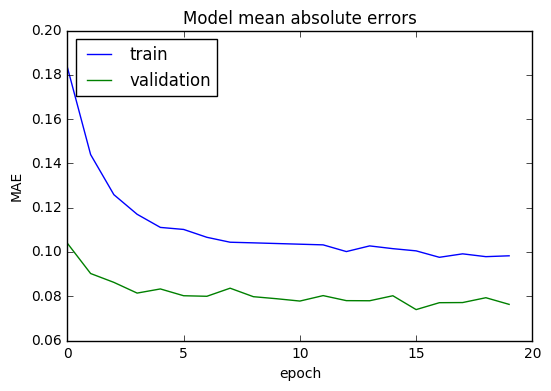

In [31]:
if isFirstRun:
    vMAE_train = np.array( history.history['mean_absolute_error'] )
    vMAE_val = np.array( history.history['val_mean_absolute_error'] )
    isFirstRun = False
else:
    vMAE_train = np.concatenate((vMAE_train[:], np.array(history.history['mean_absolute_error'])[:])  ,0)
    vMAE_val = np.concatenate((vMAE_val[:], np.array(history.history['val_mean_absolute_error'])[:])  ,0)


# plot of accuracy history
plt.plot(vMAE_train)
plt.plot(vMAE_val)
plt.title('Model mean absolute errors')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Export model architecture and weights

In [32]:
# save model architecture
with open("model.json", 'w') as file:
    file.write( model.to_json() )

# save model weights
model.save_weights("model.h5")